In [1]:
import numpy as np
import pandas as pd

import sys
import os

import PIL

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision.models import resnet50
import torch.nn as nn
import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn.functional as F

# from fastai.core import ItemBase
# from fastai.basic_data import DataBunch
from fastai.vision import *
from fastai.basic_data import DataBunch
from fastai.basic_train import Learner
from fastai.torch_core import *
from fastai.basic_data import *
from fastai.callback import *
from fastai.metrics import *

In [2]:
basedir = '../orl_faces/'

First we need to create the DataFrame whose columns are the subject ID, and the subject photo. This will have a list of all photos in the dataset.

In [3]:
### Read in the subjects. The images are in nested folders for each subject ###
subjects = os.listdir(basedir)
subjects.remove('README')

### For each discovered subject, find all the image files ###
subjects_list = []
for subject in subjects:
    for subject_photo in os.listdir(basedir + subject):
        subjects_list.append([subject, subject + '/' + subject_photo])

### Convert this all to a dataframe ###
subjectdf = pd.DataFrame(subjects_list, columns=['subject', 'subject_photo'])

Now let's create train and validation sets

In [4]:
### Split the possible subjects into two groups, train and val ###
subjects_train, subjects_val = train_test_split(subjects, test_size=5, random_state=42)

### All the classes could be used for same and different pairs, since they all have multiple examples ###
same_train, diff_train = (subjects_train, subjects_train)
same_val, diff_val = (subjects_val, subjects_val)

### Create dataframes for each train and validation ###
traindf = subjectdf[subjectdf['subject'].map(lambda x: x in subjects_train)]
valdf = subjectdf[subjectdf['subject'].map(lambda x: x in subjects_val)]

### Find out how many total images are in each, an epoch should create a pair from each (approximately) ###
train_images_per_epoch = traindf.shape[0]
val_images_per_epoch = valdf.shape[0]

In [5]:
class SiameseDataset(Dataset):
    def __init__(self, data_path, df, same, diff, id_col, image_col, images_per_epoch, transforms=None):
        """
        data_path : the high level path to get to the data folder. This could end up being the folder 
        containing all the images in a flat structure, or it could be the folder containing folders for each subject"
        id_col    : the column that contains the id of the individual object (of which there may be multiple pictures
        that will each be listed in the image_col)
        image_col : the column that contains the path to the specific image, starting in data_path"""
        self.c = 1
        self.data_path = data_path
        self.df = df
        self.same_groups = same
        self.diff_groups = diff
        self.id_col = id_col
        self.image_col = image_col
        self.images_per_epoch = images_per_epoch
        self.transform = transforms
        
    def __len__(self):
        return self.images_per_epoch #len(diff)
        
    def __getitem__(self, index):
        ### We will need to draw pairs of similar images as often as dissimilar images ###
        ### This will also function as the label we pass ###
        similar = np.random.choice([0, 1])
        
        ### To draw two dissimilar items ###
        if similar==1:
            ### Draw items from two different objects ###
            ind1, ind2 = np.random.choice(self.diff_groups, size = 2, replace=False)
            
            img1 = np.random.choice(self.df[self.df[self.id_col]==ind1][self.image_col].values)
            img2 = np.random.choice(self.df[self.df[self.id_col]==ind2][self.image_col].values)

        elif similar==0:
            ind = np.random.choice(self.same_groups)
            
            img1, img2 = np.random.choice(self.df[self.df[self.id_col]==ind][self.image_col].values, size=2, replace=False)
        
        img1 = PIL.Image.open(self.data_path + img1)
        img2 = PIL.Image.open(self.data_path + img2)
        img1 = img1.convert('RGB')
        img2 = img2.convert('RGB')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        img1 = np.array(img1, dtype=np.float32)
        img2 = np.array(img2, dtype=np.float32)
        
        return torch.from_numpy(np.array([img1, img2])), torch.from_numpy(np.array([similar], dtype=np.float32))


In [24]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs, label):
        output1, output2 = outputs
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive
    
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        ### The transfer neural network, without any fully connected layers ###
        self.transfer = resnet50(pretrained=True)
        
        freeze_layer = 7
        ct = 0
        for child in self.transfer.children():
            ct += 1
            if ct < freeze_layer:
                for param in child.parameters():
                    param.requires_grad = False

#         self.fc1 = nn.Sequential(
#             nn.Linear(1000, 500),
#             nn.ReLU(inplace=True),

#             nn.Linear(500, 500),
#             nn.ReLU(inplace=True),

#             nn.Linear(500, 5)
#         )
        self.fc1 = nn.Sequential(
            nn.ReLU(inplace=True),                            
            nn.Linear(1000, 40)
        )
    
        self.output_fc = nn.Sequential(
            nn.Linear(40, 1),
            nn.Sigmoid()
        )
        
#         self.output_fc = nn.Sequential(
#             nn.Linear(40, 1)
#         )

    def forward_once(self, x):
        output = self.transfer(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input_tuple):
#         print(input_tuple.size())
        input1 = input_tuple[:,0,:,:]
        input2 = input_tuple[:,1,:,:]
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.abs(output1 - output2)
        output = self.output_fc(output)
        return output

In [25]:
SiameseTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [26]:
train_dataset = SiameseDataset(basedir, 
                               subjectdf, 
                               same_train, 
                               diff_train, 
                               'subject', 
                               'subject_photo', 
                               train_images_per_epoch,
                               SiameseTransforms)

val_dataset = SiameseDataset(basedir, 
                               subjectdf, 
                               same_val, 
                               diff_val, 
                               'subject', 
                               'subject_photo', 
                               val_images_per_epoch,
                               SiameseTransforms)

In [29]:
train_dataloader = DataLoader(train_dataset, num_workers=8, batch_size=128)
val_dataloader   = DataLoader(val_dataset,   num_workers=8, batch_size=128)

mydb = DataBunch(train_dl=train_dataloader, valid_dl=val_dataloader)

# criterion = ContrastiveLoss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
net = SiameseNetwork()#.cuda()

learn = Learner(mydb, net, loss_func=criterion, metrics=[accuracy_thresh])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


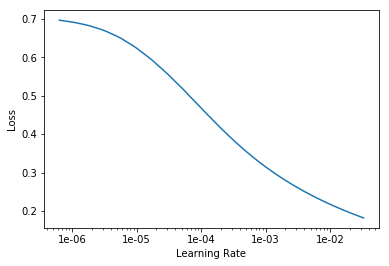

In [30]:
learn.lr_find()#start_lr=1e-5, end_lr=1.0)

learn.recorder.plot()

In [22]:
lr = 1e-2

In [17]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy_thresh
1,1.131237,437854804677492736.000000,0.540000
2,10.896227,917803630592.000000,0.460000
3,8.180896,34995.390625,0.540000
4,6.268422,407.002502,0.540000
5,5.056976,6.016704,0.580000


In [23]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.495625,0.675477,0.520000
2,0.481937,7.661680,0.580000
3,0.717272,31490.035156,0.560000
4,0.947006,13781.099609,0.460000
5,0.863195,58.576630,0.540000
6,0.780163,51.998734,0.540000
7,0.691321,16.398241,0.560000
8,0.604076,8.055422,0.540000
9,0.528952,3.128825,0.580000
10,0.466752,2.191447,0.560000


In [20]:
learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.800364,167.933258,0.540000
2,1.102139,88623386984448.000000,0.540000
3,6.296020,566784098304.000000,0.460000
4,6.082584,82857512.000000,0.460000
5,5.032815,3707673.000000,0.460000
6,4.284853,216655.687500,0.460000
7,3.669269,27431.726562,0.460000
8,3.200852,2959.366455,0.460000
9,2.832972,263.241760,0.460000
10,2.531683,24.601250,0.500000


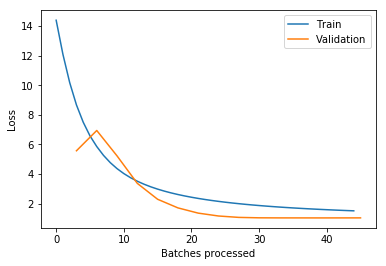

In [195]:
learn.recorder.plot_losses()

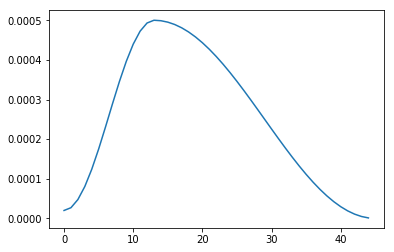

In [196]:
learn.recorder.plot_lr()

In [202]:
learn.cuda()

AttributeError: 'Learner' object has no attribute 'cuda'

In [201]:
learn.validate(val_dataloader)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same